In [ ]:
!pip install python-dotenv openai matplotlib

Executing AI-interpreted customer support operations:

Interpreting: 'Create a new ticket for customer 123 with issue 'Login problem' and priority 'Medium''
AI Response:
{
    "command_type": "CreateTicket",
    "parameters": {
        "customer_id": 123,
        "issue": "Login problem",
        "priority": "Medium"
    },
    "missing_info": []
}
Created ticket 1 for customer 123
Current tickets: {1: {'customer_id': 123, 'issue': 'Login problem', 'priority': 'Medium', 'state': 'New'}}

Interpreting: 'Create a new ticket for customer 456 with issue 'Payment failed' and priority 'Medium''
AI Response:
```json
{
    "command_type": "CreateTicket",
    "parameters": {
        "customer_id": 456,
        "issue": "Payment failed",
        "priority": "Medium"
    },
    "missing_info": []
}
```
Created ticket 2 for customer 456
Current tickets: {1: {'customer_id': 123, 'issue': 'Login problem', 'priority': 'Medium', 'state': 'New'}, 2: {'customer_id': 456, 'issue': 'Payment failed', 'prio

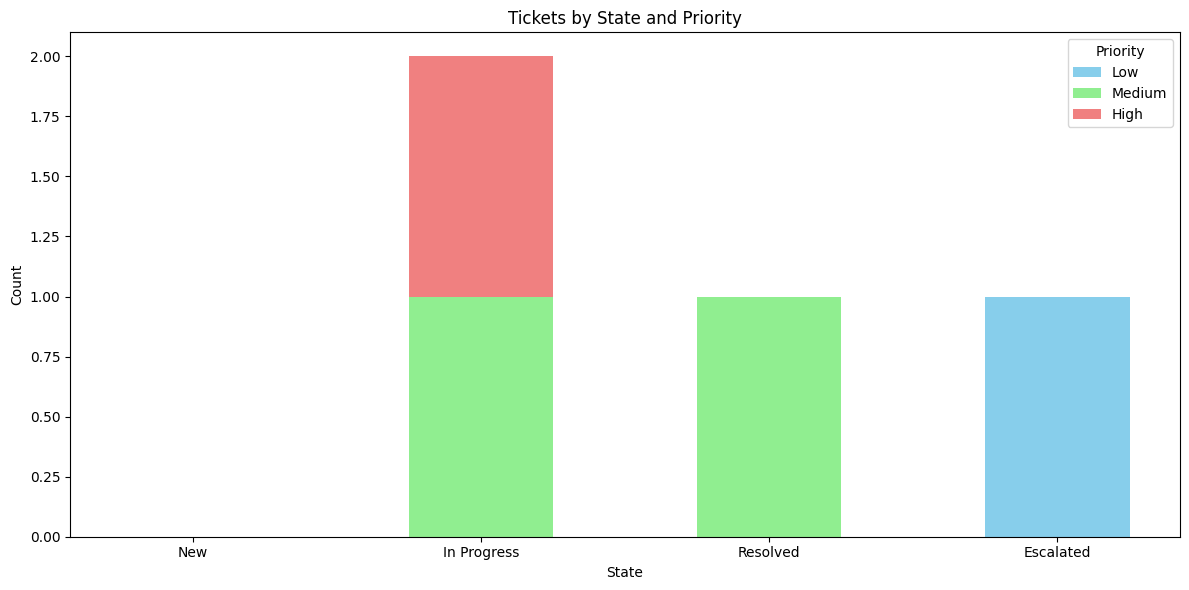

In [35]:
import json
from collections import deque
from enum import Enum
from openai import OpenAI
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

load_dotenv()
client = OpenAI()

class SupportTicketState(Enum):
    NEW = "New"
    IN_PROGRESS = "In Progress"
    RESOLVED = "Resolved"
    ESCALATED = "Escalated"

class SupportTicket:
    def __init__(self, customer_id, issue, priority):
        self.customer_id = customer_id
        self.issue = issue
        self.priority = priority
        self.state = SupportTicketState.NEW

    def update_state(self, new_state):
        self.state = new_state
        return self.state

class AICustomerSupportManager:
    def __init__(self):
        self.tickets = {}
        self.ticket_id_counter = 1
        self.history = []
        self.queued_commands = deque()

    def create_ticket(self, customer_id, issue, priority):
        ticket_id = self.ticket_id_counter
        self.tickets[ticket_id] = SupportTicket(customer_id, issue, priority)
        self.ticket_id_counter += 1
        return ticket_id

    def interpret_and_execute_command(self, natural_language_command: str) -> None:
        prompt = f"""
        Given the following customer support command and current tickets, interpret the command and provide a structured response:

        Current tickets: {self.get_tickets_dict()}
        Command: {natural_language_command}

        Respond with a JSON object in the following format:
        {{
            "command_type": "CreateTicket" or "UpdateTicket" or "EscalateTicket" or "ResolveTicket",
            "parameters": {{
                "ticket_id": ticket ID (for UpdateTicket, EscalateTicket, ResolveTicket only),
                "customer_id": customer ID (for CreateTicket only),
                "issue": "Issue description" (for CreateTicket only),
                "priority": "Low" or "Medium" or "High" (for CreateTicket only),
                "new_state": "New" or "In Progress" or "Resolved" or "Escalated" (for UpdateTicket only)
            }},
            "missing_info": ["List any missing information"] or []
        }}

        Important instructions:
        - For "Create ticket" commands, use "CreateTicket" as the command_type.
        - For "Update ticket" commands, use "UpdateTicket" as the command_type and update the ticket state.
        - For "Escalate ticket" commands, use "EscalateTicket" as the command_type and set the ticket state to "Escalated".
        - For "Resolve ticket" commands, use "ResolveTicket" as the command_type and set the ticket state to "Resolved".
        - If the command is ambiguous or lacks essential information (e.g., unspecified ticket ID or customer ID), include it in the "missing_info" list.
        - Do not assume or infer missing information. If it's not explicitly stated, list it as missing.
        """
        
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a customer support management AI assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=150
        )
        
        ai_response = response.choices[0].message.content.strip()
        print(f"AI Response:\n{ai_response}")
        
        try:
            json_content = ai_response.replace('```json', '').replace('```', '').strip()
            parsed_response = json.loads(json_content)
            
            command_type = parsed_response["command_type"].lower()
            parameters = parsed_response["parameters"]
            missing_info = parsed_response["missing_info"]
            
            validated_command = self.validate_command(command_type, parameters, missing_info)
            
            if validated_command["missing_info"]:
                print(f"Missing information for command: {', '.join(validated_command['missing_info'])}")
                self.queued_commands.append((command_type, parameters, validated_command["missing_info"]))
                print("Command added to queue.")
            else:
                self.execute_command(validated_command["command_type"], validated_command["parameters"])
        except json.JSONDecodeError:
            print(f"Error parsing AI response for command: {natural_language_command}")
            self.queued_commands.append((None, {}, ["Error parsing AI response"]))
        except Exception as e:
            print(f"Error processing command: {e}")
            self.queued_commands.append((None, {}, [f"Error: {str(e)}"]))

    def validate_command(self, command_type: str, parameters: dict, missing_info: list) -> dict:
        validated = {"command_type": command_type, "parameters": parameters, "missing_info": missing_info}
        
        if command_type == "createticket" and (not parameters.get("customer_id") or not parameters.get("issue") or not parameters.get("priority")):
            validated["missing_info"].append("Customer ID, issue, or priority not specified")
        
        if command_type in ["updateticket", "escalateticket", "resolveticket"] and not parameters.get("ticket_id"):
            validated["missing_info"].append("Ticket ID not specified")
        
        return validated

    def execute_command(self, command_type: str, parameters: dict) -> None:
        if command_type == "createticket":
            customer_id = parameters["customer_id"]
            issue = parameters["issue"]
            priority = parameters["priority"]
            ticket_id = self.create_ticket(customer_id, issue, priority)
            print(f"Created ticket {ticket_id} for customer {customer_id}")
        else:
            ticket_id = int(parameters["ticket_id"])
            if ticket_id not in self.tickets:
                raise ValueError(f"Ticket ID {ticket_id} does not exist")

            if command_type == "updateticket":
                new_state = parameters["new_state"]
                self.tickets[ticket_id].update_state(SupportTicketState[new_state.upper().replace(" ", "_")])
                print(f"Updated ticket {ticket_id} to {new_state}")
            elif command_type == "escalateticket":
                self.tickets[ticket_id].update_state(SupportTicketState.ESCALATED)
                print(f"Escalated ticket {ticket_id}")
            elif command_type == "resolveticket":
                self.tickets[ticket_id].update_state(SupportTicketState.RESOLVED)
                print(f"Resolved ticket {ticket_id}")
            else:
                raise ValueError(f"Unknown command type: {command_type}")
        
        print(f"Current tickets: {self.get_tickets_dict()}")

    def get_tickets_dict(self):
        return {ticket_id: {
            "customer_id": ticket.customer_id,
            "issue": ticket.issue,
            "priority": ticket.priority,
            "state": ticket.state.value
        } for ticket_id, ticket in self.tickets.items()}

def visualize_tickets_and_queue(tickets, queued_commands):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Prepare data for stacked bar chart
    states = ["New", "In Progress", "Resolved", "Escalated"]
    priorities = ["Low", "Medium", "High"]
    state_priority_counts = {state: {priority: 0 for priority in priorities} for state in states}

    for ticket in tickets.values():
        state_priority_counts[ticket.state.value][ticket.priority] += 1

    # Stack bars for each state by priority
    bar_width = 0.5
    bar_positions = np.arange(len(states))
    bottom = np.zeros(len(states))

    colors = {
        "Low": "skyblue",
        "Medium": "lightgreen",
        "High": "lightcoral"
    }

    for priority in priorities:
        counts = [state_priority_counts[state][priority] for state in states]
        ax.bar(bar_positions, counts, bar_width, bottom=bottom, color=colors[priority], label=priority)
        bottom += np.array(counts)

    ax.set_title("Tickets by State and Priority")
    ax.set_xlabel("State")
    ax.set_ylabel("Count")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(states)
    ax.legend(title="Priority")

    plt.tight_layout()
    plt.show()

# Example usage with manager object
manager = AICustomerSupportManager()

# More diverse sample dataset
natural_language_commands = [
    "Create a new ticket for customer 123 with issue 'Login problem' and priority 'Medium'",
    "Create a new ticket for customer 456 with issue 'Payment failed' and priority 'Medium'",
    "Create a new ticket for customer 789 with issue 'Account locked' and priority 'Low'",
    "Create a new ticket for customer 321 with issue 'Unable to update profile' and priority 'High'",
    "Update ticket 1 to 'In Progress'",
    "Update ticket 2 to 'In Progress'",
    "Escalate ticket 3",
    "Resolve ticket 2",
    "Update ticket 4 to 'In Progress'",
]

print("Executing AI-interpreted customer support operations:")
for command in natural_language_commands:
    print(f"\nInterpreting: '{command}'")
    manager.interpret_and_execute_command(command)

print("\nFinal tickets:")
print(manager.get_tickets_dict())

print("\nQueued commands:")
for cmd in manager.queued_commands:
    print(f"Type: {cmd[0]}, Parameters: {cmd[1]}, Missing Info: {cmd[2]}")

print("\nVisualizing tickets and queued commands:")
visualize_tickets_and_queue(manager.tickets, manager.queued_commands)